In [1]:
import os
import sys
# 如果当前代码文件运行测试需要加入修改路径，避免出现后导包问题
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(0, os.path.join(BASE_DIR))

PYSPARK_PYTHON = "/miniconda2/envs/reco_sys/bin/python"
# 当存在多个版本时，不指定很可能会导致出错
os.environ["PYSPARK_PYTHON"] = PYSPARK_PYTHON
os.environ["PYSPARK_DRIVER_PYTHON"] = PYSPARK_PYTHON

from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from offline import SparkSessionBase

class CtrLogisticRegression(SparkSessionBase):

    SPARK_APP_NAME = "ctrLogisticRegression"
    ENABLE_HIVE_SUPPORT = True

    def __init__(self):

        self.spark = self._create_spark_hbase()

ctr = CtrLogisticRegression()

In [3]:
# 2、读取用户点击行为表，与用户画像和文章画像，构造训练样本
ctr.spark.sql('use profile')
news_article_basic = ctr.spark.sql("select user_id, article_id, channel_id, clicked from user_article_basic")

In [4]:
news_article_basic.show()

+-------------------+-------------------+----------+-------+
|            user_id|         article_id|channel_id|clicked|
+-------------------+-------------------+----------+-------+
|1105045287866466304|              14225|         0|  false|
|1106476833370537984|              14208|         0|  false|
|1109980466942836736|              19233|         0|  false|
|1109980466942836736|              44737|         0|  false|
|1109993249109442560|              17283|         0|  false|
|1111189494544990208|              19322|         0|  false|
|1111524501104885760|              44161|         0|  false|
|1112727762809913344|              18172|        18|   true|
|1113020831425888256|1112592065390182400|         0|  false|
|1114863735962337280|              17665|         0|  false|
|1114863741448486912|              14208|         0|  false|
|1114863751909081088|              13751|         0|  false|
|1114863846486441984|              17940|         0|  false|
|1114863941936218112|   

In [5]:
# 获取用户画像的数据
user_profile_hbase = ctr.spark.sql(
    "select user_id, information.birthday, information.gender, article_partial, env from user_profile_hbase")
user_profile_hbase = user_profile_hbase.drop('env')

In [6]:
user_profile_hbase.show()

+--------------------+--------+------+--------------------+
|             user_id|birthday|gender|     article_partial|
+--------------------+--------+------+--------------------+
|              user:1|     0.0|  null|Map(18:vars -> 0....|
|             user:10|     0.0|  null|Map(18:tp2 -> 0.2...|
|             user:11|     0.0|  null|               Map()|
|user:110249052282...|     0.0|  null|               Map()|
|user:110319567345...|    null|  null|Map(18:Animal -> ...|
|user:110504528786...|    null|  null|Map(18:text -> 0....|
|user:110509388310...|    null|  null|Map(18:text -> 0....|
|user:110510518565...|    null|  null|Map(18:SHOldboySt...|
|user:110639618314...|    null|  null|Map(18:tp2 -> 0.2...|
|user:110647320376...|    null|  null|Map(18:text -> 0....|
|user:110647683337...|    null|  null|Map(18:text -> 1....|
|user:110826490119...|    null|  null|Map(18:text -> 0....|
|user:110997636345...|    null|  null|Map(18:text -> 0....|
|user:110997980510...|    null|  null|Ma

In [8]:
# 对用户ID做处理
def get_user_id(row):
    return int(row.user_id.split(':')[1]), row.birthday, row.gender, row.article_partial

user_profile_hbase = user_profile_hbase.rdd.map(get_user_id)

In [9]:
# 对于其中toDF存在一些列没办法确定类型，手动指定DataFrame列的类型
_schema = StructType([
    StructField('user_id', LongType()),
    StructField('birthday', DoubleType()),
    StructField('gender', BooleanType()),
    StructField('article_partial', MapType(StringType(), DoubleType()))
])

user_profile_hbase = ctr.spark.createDataFrame(user_profile_hbase, schema=_schema)

In [11]:
user_profile_hbase.show()

+-------------------+--------+------+--------------------+
|            user_id|birthday|gender|     article_partial|
+-------------------+--------+------+--------------------+
|                  1|     0.0|  null|Map(18:vars -> 0....|
|                 10|     0.0|  null|Map(18:tp2 -> 0.2...|
|                 11|     0.0|  null|               Map()|
|1102490522829717504|     0.0|  null|               Map()|
|1103195673450250240|    null|  null|Map(18:Animal -> ...|
|1105045287866466304|    null|  null|Map(18:text -> 0....|
|1105093883106164736|    null|  null|Map(18:text -> 0....|
|1105105185656537088|    null|  null|Map(18:SHOldboySt...|
|1106396183141548032|    null|  null|Map(18:tp2 -> 0.2...|
|1106473203766657024|    null|  null|Map(18:text -> 0....|
|1106476833370537984|    null|  null|Map(18:text -> 1....|
|1108264901190615040|    null|  null|Map(18:text -> 0....|
|1109976363453906944|    null|  null|Map(18:text -> 0....|
|1109979805106831360|    null|  null|Map(18:text -> 0...

In [20]:
# 合并用户点击行为表与用户画像表，并进行相应的删除无用特征
train = news_article_basic.join(user_profile_hbase, on=['user_id'], how='left').drop('birthday').drop('channel_id').drop('gender')



In [16]:
train.show()

+-------------------+----------+-------+--------------------+
|            user_id|article_id|clicked|     article_partial|
+-------------------+----------+-------+--------------------+
|1106473203766657024|     16005|  false|Map(18:text -> 0....|
|1106473203766657024|     44664|  false|Map(18:text -> 0....|
|1106473203766657024|     44386|  false|Map(18:text -> 0....|
|1106473203766657024|     14335|  false|Map(18:text -> 0....|
|1106473203766657024|     13778|  false|Map(18:text -> 0....|
|1106473203766657024|     13039|  false|Map(18:text -> 0....|
|1106473203766657024|     13648|  false|Map(18:text -> 0....|
|1106473203766657024|     17304|  false|Map(18:text -> 0....|
|1106473203766657024|     19233|  false|Map(18:text -> 0....|
|1106473203766657024|     44466|  false|Map(18:text -> 0....|
|1106473203766657024|     18795|  false|Map(18:text -> 0....|
|1106473203766657024|    134812|  false|Map(18:text -> 0....|
|1106473203766657024|     13357|  false|Map(18:text -> 0....|
|1106473

In [17]:
# 合并文章的向量以及文章的权重特征，文章所属的真正频道ID
ctr.spark.sql('use article')
article_vector = ctr.spark.sql("select * from article_vector")

In [21]:
train_user_article = train.join(article_vector, on=['article_id'], how='left')

In [22]:
train_user_article.show()

+----------+-------------------+-------+--------------------+----------+--------------------+
|article_id|            user_id|clicked|     article_partial|channel_id|       articlevector|
+----------+-------------------+-------+--------------------+----------+--------------------+
|     13401|1114864237131333632|  false|Map(18:vars -> 0....|        18|[0.06157120217893...|
|     13401|                 10|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|
|     13401|1106396183141548032|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|
|     13401|1109994594201763840|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|
|     14805|1106473203766657024|  false|Map(18:text -> 0....|        18|[0.11028526511434...|
|     14805|1113049054452908032|  false|Map(18:text -> 0....|        18|[0.11028526511434...|
|     14805|1114863751909081088|   true|Map(18:text -> 2....|        18|[0.11028526511434...|
|     14805|1115534909935452160|  false|Map(18:text -> 2....

In [24]:
# 读取文章画像
article_profile = ctr.spark.sql("select article_id, keywords from article_profile")

def get_article_weights(row):
    
    try:
        weights = sorted(row.keywords.values())[:10]
    except Exception as e:
        weights = [0.0] * 10
    
    return row.article_id, weights

article_profile = article_profile.rdd.map(get_article_weights).toDF(['article_id', 'article_weights'])

In [26]:
# 合并文章权重与样本
train_user_article = train_user_article.join(article_profile, on=['article_id'], how='left')

In [27]:
train_user_article.show()

+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|article_id|            user_id|clicked|     article_partial|channel_id|       articlevector|     article_weights|
+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|     13401|1114864237131333632|  false|Map(18:vars -> 0....|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|                 10|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|1106396183141548032|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|1109994594201763840|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|[0.08196639249252...|
|     14805|1106473203766657024|  false|Map(18:text -> 0....|        18|[0.11028526511434...|[0.15069781969741...|
|     14805|1113049054452908032|  false|Map(18:text -> 0....|        18|[0.11028

In [28]:
# 保留了用户的每个频道的关键词权重，找到用户对应操作文章的所属频道的关键词权重
train_user_article = train_user_article.dropna()

In [30]:
train_user_article.show()

+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|article_id|            user_id|clicked|     article_partial|channel_id|       articlevector|     article_weights|
+----------+-------------------+-------+--------------------+----------+--------------------+--------------------+
|     13401|1114864237131333632|  false|Map(18:vars -> 0....|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|                 10|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|1106396183141548032|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|[0.08196639249252...|
|     13401|1109994594201763840|  false|Map(18:tp2 -> 0.2...|        18|[0.06157120217893...|[0.08196639249252...|
|     14805|1106473203766657024|  false|Map(18:text -> 0....|        18|[0.11028526511434...|[0.15069781969741...|
|     14805|1113049054452908032|  false|Map(18:text -> 0....|        18|[0.11028

In [37]:
train_user_article

DataFrame[article_id: bigint, user_id: bigint, clicked: boolean, article_partial: map<string,double>, channel_id: int, articlevector: array<double>, article_weights: array<double>]

In [40]:
columns = ['article_id', 'user_id', 'channel_id', 'articlevector', 'user_weights', 'article_weights', 'clicked']
def get_user_weights(row):

    from pyspark.ml.linalg import Vectors
    try:
        user_weights = sorted([row.article_partial[key] for key in row.article_partial.keys() if key.split(':')[0] == str(row.channel_id)])[
                  :10]
    except Exception:
        user_weights = [0.0] * 10

    return row.article_id, row.user_id, row.channel_id, Vectors.dense(row.articlevector), Vectors.dense(
        user_weights), Vectors.dense(row.article_weights), int(row.clicked)

train_vector = train_user_article.rdd.map(get_user_weights).toDF(columns)





In [43]:
# 收集所有特征到一个features列
train_res = VectorAssembler().setInputCols(columns[2:6]).setOutputCol('features').transform(train_vector)

In [46]:
train_res

DataFrame[article_id: bigint, user_id: bigint, channel_id: bigint, articlevector: vector, user_weights: vector, article_weights: vector, clicked: bigint, features: vector]

In [48]:
lr = LogisticRegression()
model = lr.setLabelCol("clicked").setFeaturesCol("features").fit(train_res)
model.save("hdfs://hadoop-master:9000/headlines/models/LR.obj")

In [50]:
online_model = LogisticRegressionModel.load("hdfs://hadoop-master:9000/headlines/models/LR.obj")

In [51]:
res = online_model.transform(train_res)

In [53]:
res_transfrom = res.select(['clicked', 'probability', 'prediction'])

In [54]:
res_transfrom.show()

+-------+--------------------+----------+
|clicked|         probability|prediction|
+-------+--------------------+----------+
|      0|[0.94070130103808...|       0.0|
|      0|[0.91016787505517...|       0.0|
|      0|[0.91442962771916...|       0.0|
|      0|[0.92014021303552...|       0.0|
|      0|[0.92898403826816...|       0.0|
|      0|[0.94214051605333...|       0.0|
|      1|[0.95102655533425...|       0.0|
|      0|[0.95687331753244...|       0.0|
|      0|[0.92601117859403...|       0.0|
|      0|[0.92738910925408...|       0.0|
|      0|[0.95102655533425...|       0.0|
|      0|[0.93379365069688...|       0.0|
|      0|[0.93772847639518...|       0.0|
|      0|[0.92738910925408...|       0.0|
|      0|[0.95102655533425...|       0.0|
|      0|[0.95102655533425...|       0.0|
|      0|[0.95687331753244...|       0.0|
|      0|[0.95102655533425...|       0.0|
|      0|[0.95368571992130...|       0.0|
|      0|[0.95102655533425...|       0.0|
+-------+--------------------+----

In [60]:
def get_probility(row):
    return float(row.clicked), float(row.probability[1]) 

score_label = res_transfrom.rdd.map(get_probility)

In [56]:
score_label.show()
# 点击率都是比较小的值

+-------+--------------------+
|clicked|         probability|
+-------+--------------------+
|    0.0|0.059298698961917994|
|    0.0| 0.08983212494482244|
|    0.0| 0.08557037228083761|
|    0.0| 0.07985978696447615|
|    0.0| 0.07101596173183954|
|    0.0| 0.05785948394666966|
|    1.0| 0.04897344466574041|
|    0.0| 0.04312668246755366|
|    0.0|  0.0739888214059692|
|    0.0| 0.07261089074591476|
|    0.0| 0.04897344466574041|
|    0.0| 0.06620634930311975|
|    0.0| 0.06227152360481189|
|    0.0| 0.07261089074591476|
|    0.0| 0.04897344466574041|
|    0.0| 0.04897344466574041|
|    0.0| 0.04312668246755366|
|    0.0| 0.04897344466574041|
|    0.0| 0.04631428007869333|
|    0.0| 0.04897344466574041|
+-------+--------------------+
only showing top 20 rows



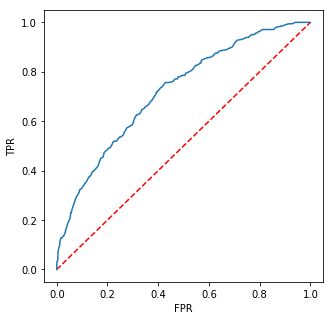

In [58]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(model.summary.roc.select('FPR').collect(),
         model.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [61]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
roc = BinaryClassificationMetrics(score_label)
roc.areaUnderROC

0.7364334522585716

In [62]:
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

In [63]:
arr = np.array(score_label.collect())

In [64]:
accuracy_score(arr[:, 0], arr[:, 1].round())

0.9054726368159204

In [75]:
# 用户特征的构建存储
# 构造样本
ctr.spark.sql("use profile")

user_profile_hbase = ctr.spark.sql(
    "select user_id, information.birthday, information.gender, article_partial, env from user_profile_hbase")

# 特征工程处理
# 抛弃获取值少的特征
user_profile_hbase = user_profile_hbase.drop('env', 'birthday', 'gender')

def get_user_id(row):
    return int(row.user_id.split(":")[1]), row.article_partial

user_profile_hbase_temp = user_profile_hbase.rdd.map(get_user_id)

from pyspark.sql.types import *

_schema = StructType([
    StructField("user_id", LongType()),
    StructField("weights", MapType(StringType(), DoubleType()))
])

user_profile_hbase_schema = ctr.spark.createDataFrame(user_profile_hbase_temp, schema=_schema)

In [76]:
user_profile_hbase_schema.show()

+-------------------+--------------------+
|            user_id|             weights|
+-------------------+--------------------+
|                  1|Map(18:vars -> 0....|
|                 10|Map(18:tp2 -> 0.2...|
|1103195673450250240|Map(18:Animal -> ...|
|1105045287866466304|Map(18:text -> 0....|
|1105093883106164736|Map(18:text -> 0....|
|1105105185656537088|Map(18:SHOldboySt...|
|1106396183141548032|Map(18:tp2 -> 0.2...|
|1106473203766657024|Map(18:text -> 0....|
|1106476833370537984|Map(18:text -> 1....|
|1108264901190615040|Map(18:text -> 0....|
|1109976363453906944|Map(18:text -> 0....|
|1109979805106831360|Map(18:text -> 0....|
|1109980466942836736|Map(18:text -> 0....|
|1109984273839947776|Map(18:text -> 0....|
|1109993249109442560|Map(18:text -> 0....|
|1109994594201763840|Map(18:tp2 -> 0.2...|
|1109995264376045568|Map(18:text -> 0....|
|1109995683777085440|Map(18:text -> 0....|
|1110071654421102592|Map(18:text -> 0....|
|1111189494544990208|Map(18:text -> 0....|
+----------

In [78]:
def feature_process(row):
    
    channel_weights = []
    for i in range(1, 26):
        try:
            w = sorted([row.weights[key] for key in row.weights.keys() if key.split(':')[0] == str(i)])[:10]
            channel_weights.append(w)
        except:
            channel_weights.append([0.0] * 10)
    return row.user_id, channel_weights

res = user_profile_hbase_schema.rdd.map(feature_process).collect()

In [80]:
# res

[(1,
  [[],
   [],
   [],
   [],
   [],
   [],
   [1.659209773072352],
   [],
   [],
   [],
   [],
   [],
   [1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748,
    1.6439270311265748],
   [],
   [],
   [],
   [],
   [0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846],
   [],
   [],
   [],
   [],
   [],
   [],
   []]),
 (10,
  [[],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [],
   [0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.21215332784742846,
    0.2121533278474284

In [81]:
# 存储Hbase当中
import happybase
pool = happybase.ConnectionPool(size=10, host='hadoop-master', port=9090)
with pool.connection() as conn:
    ctr_feature_user = conn.table('ctr_feature_user')
    with ctr_feature_user.batch(transaction=True) as b:
        for i in range(len(res)):
            # user_id res[i][0]
            # feature res[i][1]
            for j in range(25):
                b.put(str(res[i][0]).encode(), {
                    'channel:{}'.format(j+1).encode(): str(res[i][1][j]).encode()
                })
    conn.close() 

In [82]:
# 文章特征中心
ctr.spark.sql("use article")
article_profile = ctr.spark.sql("select * from article_profile")
def article_profile_to_feature(row):
    try:
        weights = sorted(row.keywords.values())[:10]
    except Exception as e:
        weights = [0.0] * 10
    return row.article_id, row.channel_id, weights
article_profile = article_profile.rdd.map(article_profile_to_feature).toDF(['article_id', 'channel_id', 'weights'])

article_vector = ctr.spark.sql("select * from article_vector")
article_feature = article_profile.join(article_vector, on=['article_id'], how='inner')
def feature_to_vector(row):
    from pyspark.ml.linalg import Vectors
    return row.article_id, row.channel_id, Vectors.dense(row.weights), Vectors.dense(row.articlevector)
article_feature = article_feature.rdd.map(feature_to_vector).toDF(['article_id', 'channel_id', 'weights', 'articlevector'])

# 保存特征数据
cols2 = ['article_id', 'channel_id', 'weights', 'articlevector']
# 做特征的指定指定合并
article_feature_two = VectorAssembler().setInputCols(cols2[1:4]).setOutputCol("features").transform(article_feature)


In [83]:
article_feature_two.show()

+----------+----------+--------------------+--------------------+--------------------+
|article_id|channel_id|             weights|       articlevector|            features|
+----------+----------+--------------------+--------------------+--------------------+
|        26|        17|[0.19827163395829...|[0.02069368539384...|[17.0,0.198271633...|
|        29|        17|[0.26031398249056...|[-0.1446092289546...|[17.0,0.260313982...|
|       474|        17|[0.49818598558926...|[0.17293323921293...|[17.0,0.498185985...|
|      1677|        17|[0.19827339246090...|[-0.1303829028565...|[17.0,0.198273392...|
|      1697|         6|[0.25105539265038...|[0.05229978313861...|[6.0,0.2510553926...|
|      1806|        17|[0.18449119772340...|[0.02166337053188...|[17.0,0.184491197...|
|      1950|        17|[0.33331407122173...|[-0.3318378543653...|[17.0,0.333314071...|
|      2040|        17|[0.38583431341698...|[-0.0164312324191...|[17.0,0.385834313...|
|      2250|         6|[0.46477621366740...

In [ ]:
def save_article_feature_to_hbase(partition):
    import happybase
    pool = happybase.ConnectionPool(size=10, host='hadoop-master')
    with pool.connection() as conn:
        table = conn.table('ctr_feature_article')
        for row in partition:
            table.put('{}'.format(row.article_id).encode(),
                     {'article:{}'.format(row.article_id).encode(): str(row.features).encode()})

article_feature_two.foreachPartition(save_article_feature_to_hbase)